# Deep Learning Exploratory Data Analysis

============================================

Setting the seed is rather complex in CNNs

In [9]:
# Seed value
seed_value= 0
 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
 
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
 
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
 
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

#navigate folders
import os
from glob import glob

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to open images
import cv2

#to display all columns
pd.set_option('display.max_columns', None)

In [2]:
# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Evaluation model
from sklearn.metrics import confusion_matrix

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# for CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam 
from keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing import image
from tensorflow.keras import utils as np_utils

## Load Images and Data

In [5]:
# Data directory
DATA_FOLDER = r"D:\Downloads\v2-plant-seedlings-dataset"

In [6]:
# List of all the folders in the data directory
os.listdir(DATA_FOLDER)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [7]:
# Crawl through the directory

for class_folder in os.listdir(DATA_FOLDER):
    print(f"{class_folder}: {len(os.listdir(os.path.join(DATA_FOLDER, class_folder)))} images")

Black-grass: 309 images
Charlock: 452 images
Cleavers: 335 images
Common Chickweed: 713 images
Common wheat: 253 images
Fat Hen: 538 images
Loose Silky-bent: 762 images
Maize: 257 images
Scentless Mayweed: 607 images
Shepherds Purse: 274 images
Small-flowered Cranesbill: 576 images
Sugar beet: 463 images


In [8]:
# Create a dataframe that stores the path to the image in one column and the class of the target in the enxt

image_df = []

for class_folder in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder)

    #Collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        tmp = pd.DataFrame({"image": [image_path], "target": [class_folder]}).T
        image_df.append(tmp)
    
#concate the final dataframe
image_df = pd.concat(image_df, axis=1).T.reset_index(drop=True)
image_df.head()


,image,target
0,D:\Downloads\v2-plant-seedlings-dataset\Black-...,Black-grass
1,D:\Downloads\v2-plant-seedlings-dataset\Black-...,Black-grass
2,D:\Downloads\v2-plant-seedlings-dataset\Black-...,Black-grass
3,D:\Downloads\v2-plant-seedlings-dataset\Black-...,Black-grass
4,D:\Downloads\v2-plant-seedlings-dataset\Black-...,Black-grass


In [9]:
# quick sanity check using value counts
image_df.target.value_counts()

target
Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: count, dtype: int64

In [10]:
# Plot bunch of images together

def plot_for_class(df, label):
    nb_rows = 3
    nb_cols = 3

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df.target == label].reset_index(drop=True)
            img = cv2.imread(tmp.loc[n, "image"])
            axs[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            n+=1



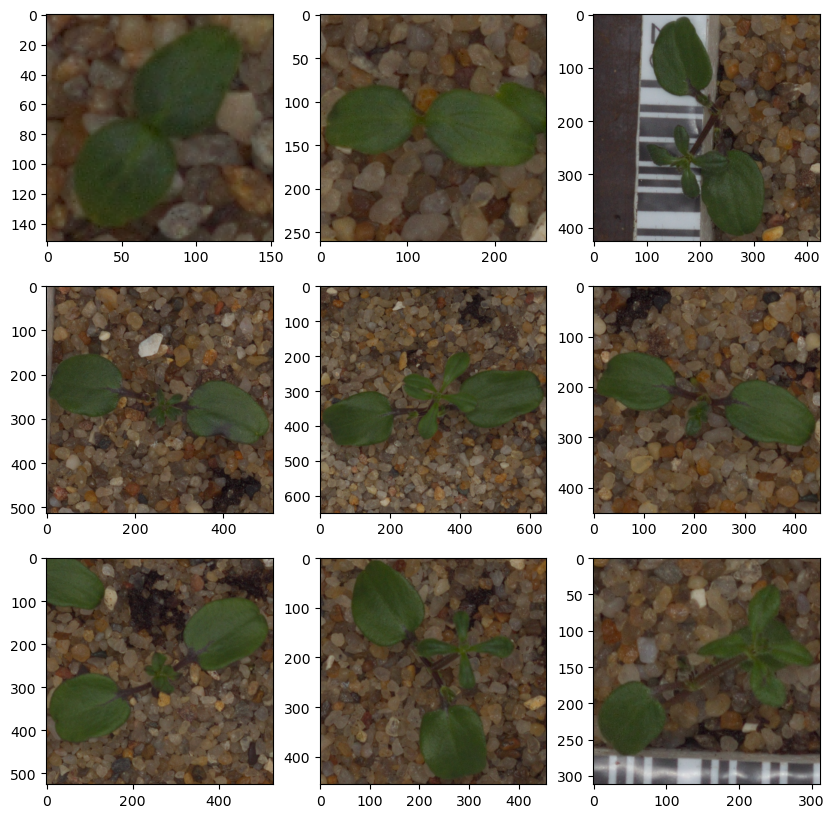

In [11]:
plot_for_class(image_df, "Cleavers")

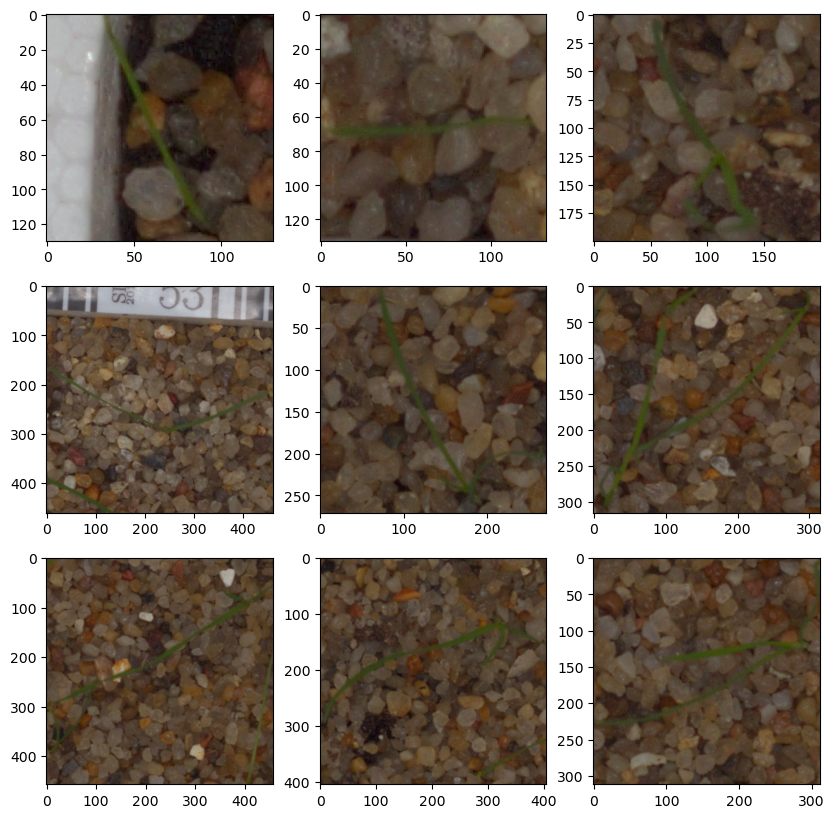

In [12]:
plot_for_class(image_df, "Loose Silky-bent")

## Separate Train and Test Set

Set a seed for reproducibility

In [13]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(image_df['image'], image_df['target'], test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [14]:
# Reset index for both train and test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Target Variables too
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
# Quick calculate for % of images within each class in train and test
y_train.value_counts(normalize=True)

target
Loose Silky-bent             0.138118
Common Chickweed             0.129542
Scentless Mayweed            0.111262
Small-flowered Cranesbill    0.103363
Fat Hen                      0.095012
Sugar beet                   0.084180
Charlock                     0.082148
Cleavers                     0.060032
Black-grass                  0.055969
Shepherds Purse              0.051230
Common wheat                 0.044911
Maize                        0.044234
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

target
Loose Silky-bent             0.135379
Common Chickweed             0.125451
Small-flowered Cranesbill    0.106498
Fat Hen                      0.105596
Scentless Mayweed            0.102888
Sugar beet                   0.081227
Charlock                     0.079422
Cleavers                     0.062274
Black-grass                  0.055054
Maize                        0.055054
Common wheat                 0.048736
Shepherds Purse              0.042419
Name: proportion, dtype: float64

## Data Preprocessing for CNN

Let's prepare the target using multiclass classification

In [17]:
encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [18]:
# Since images are in different sizes, we need to resize them to a common size

IMAGE_SIZE = 150

In [19]:
def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [20]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

In [21]:
# Since the shape of datasets needs to be (n1, n2, n3, n4)
# where n1 is number of observations
# n2 and n3 are the image width and length
# n4 indicates if it is colored, so 3 planes per image

def create_dataset(df, image_size):
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype = 'float32')

    for n in range(0, len(df)):
        tmp[n] = im_resize(df, n)
    
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [22]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [23]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [24]:
# Number of different classes
len(y_train.unique())

12

# Building the CNN

In [25]:
kernel_size = (3, 3)
pool_size= (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
#model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,663,148 (29.23 MB)

 Trainable params: 7,663,148 (29.23 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
batch_size = 10
epochs = 8

In [30]:
filepath = r"C:\Users\d0tam\Housing-Prices-ML-Model\deep-learning-model\model\model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=1, verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x_train, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, test_y), callbacks=callbacks_list)

Epoch 1/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.1317 - loss: 6.0174 - val_accuracy: 0.3727 - val_loss: 2.1285 - learning_rate: 1.0000e-04
Epoch 2/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.3424 - loss: 1.9471 - val_accuracy: 0.5072 - val_loss: 1.6060 - learning_rate: 1.0000e-04
Epoch 3/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.4867 - loss: 1.5040 - val_accuracy: 0.6273 - val_loss: 1.2470 - learning_rate: 1.0000e-04
Epoch 4/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.6107 - loss: 1.1518 - val_accuracy: 0.6679 - val_loss: 1.0820 - learning_rate: 1.0000e-04
Epoch 5/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.6806 - loss: 0.9572 - val_accuracy: 0.7283 - val_loss: 0.9221 - learning_rate: 1.0000e-04
Epoch 6/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.6909 - loss: 0.9107 - val_accuracy: 0.7509 - val_loss: 0.8499 - learning_rate: 1.0000e-04
Epoch 7/8
444/444 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - acc

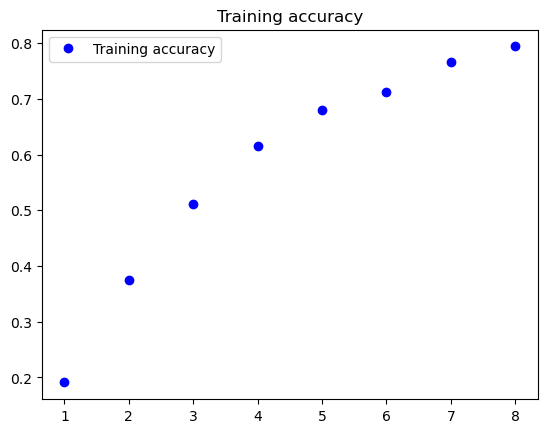

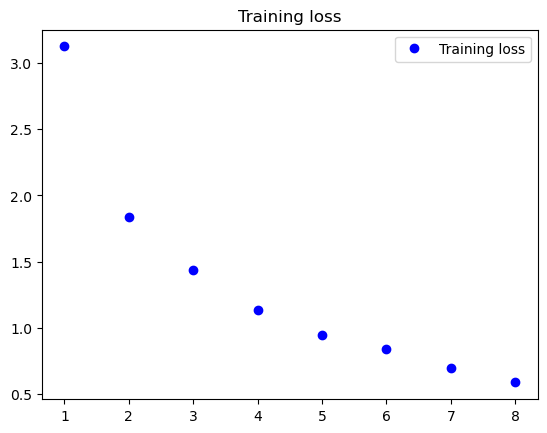

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()


In [37]:
# make a prediction

predictions = np.argmax(model.predict(x_test), axis=-1)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [38]:
# inspect predictions
predictions

array([ 6,  4, 11, ...,  5,  9,  5], dtype=int64)

In [39]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [41]:
# Create a dict to map back the numbers to the class names

tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis = 1)

tmp.columns = ['target', 'target_num']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)

tmp = pd.Series(tmp.target.values, index=tmp.target_num).to_dict()
tmp

{6: 'Loose Silky-bent',
 0: 'Black-grass',
 11: 'Sugar beet',
 3: 'Common Chickweed',
 2: 'Cleavers',
 9: 'Shepherds Purse',
 1: 'Charlock',
 8: 'Scentless Mayweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 10: 'Small-flowered Cranesbill',
 7: 'Maize'}

In [42]:
abbreviations = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

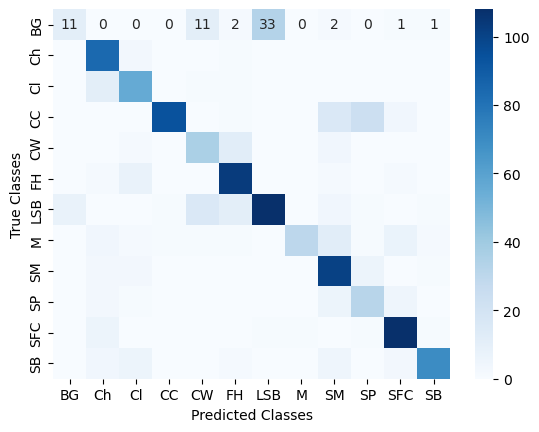

In [43]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Blues, annot=True)
ax.set_xticklabels(abbreviations)
ax.set_yticklabels(abbreviations)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(encoder.transform(y_test), predictions , normalize = True, sample_weight=None)

0.7518050541516246